In [28]:

import numpy as np
import pandas as pd
import datetime
import glob
#from tqdm.auto import tqdm
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
#import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
#from dash import Dash, html, dcc
import tkinter
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF8')

import warnings
warnings.filterwarnings("ignore")


In [29]:
import configparser

config = configparser.ConfigParser()
config.read('strategy_config.ini')

strategy_path = config['base']['path']
report_path = config['base']['report_path']
report_plot_path = config['base']['report_plot_path']
trading_day_date_path = config['base']['trading_day_date_path']
file_type = config['base']['file_type']
img_path = config['base']['img_path']
twa02_path = config['base']['twa02_path']
strategy_report_paths = glob.glob(strategy_path + '*' + file_type)
intraday_start_day = datetime.strptime(config['base']['intraday_start_day'], '%Y-%m-%d')
year_days = int(config['base']['year_days'])
transaction_cost = float(config['base']['transaction_cost'])
risk_free_rate = float(config['base']['risk_free_rate'])

total_asset = float(config['allocation']['total_asset'])
risk_factor = float(config['allocation']['risk_factor'])
strategy_risk_factor = float(config['allocation']['strategy_risk_factor'])
stock_risk_factor = float(config['allocation']['stock_risk_factor'])

portfolio_intraday_init_asset = float(config['portfolio_threshold']['portfolio_intraday_init_asset'])

backtesting_start_date = datetime(2021,1,1)


In [30]:

from backtesting.strategy import Strategy
from backtesting.portfolio import Portfolio_intraday, Portfolio_interday, Portfolio
from backtesting.evaluate import get_MDD

portfolio_interday_paths = glob.glob('./portfolio_interday/' + '*' + file_type)
portfolio_intraday_paths = glob.glob('./portfolio_intraday/' + '*' + file_type)

portfolio_cols = []
if portfolio_intraday_paths:
    print('\r Preparing intraday ...', end = '', flush=True)
    portfolio_intraday = Portfolio_intraday(name = 'portfolio_intraday', portfolio_intraday_init_asset = portfolio_intraday_init_asset, portfolio_path = portfolio_intraday_paths)
    portfolio_intraday.get_plotly_html()
    portfolio_cols += portfolio_intraday.portfolio_cols
    portfolio_df = portfolio_intraday.daily_report
    portfolio_trading_record_df = portfolio_intraday.tradingRecords

if portfolio_interday_paths:
    print('\r Preparing interday ...', end = '', flush=True)
    portfolio_interday = Portfolio_interday(name = 'portfolio_interday', portfolio_path = portfolio_interday_paths)
    portfolio_interday.get_plotly_html()
    portfolio_cols += portfolio_interday.portfolio_cols
    portfolio_df = portfolio_interday.daily_report
    portfolio_trading_record_df = portfolio_interday.tradingRecords

if portfolio_intraday_paths and portfolio_interday_paths:
    portfolio_df = pd.merge(portfolio_intraday.daily_report, portfolio_interday.daily_report, on=['Date'], how='outer')
    portfolio_df = portfolio_df.sort_values(by = ['Date']).reset_index(drop=True)
    portfolio_trading_record_df = pd.concat([portfolio_intraday.tradingRecords, portfolio_interday.tradingRecords]).sort_values(by = ['inDate']).reset_index(drop=True)

print('\r Completed intraday and interday portfolio preparation')
portfolio = Portfolio(portfolio_report = portfolio_df, portfolio_trading_record = portfolio_trading_record_df, portfolio_cols = portfolio_cols)


 Completed intraday and interday portfolio preparation


In [31]:

def get_preformance(profit_series, holding_money_series):
    return [round(profit_series.sum() / 10000, 2), 
    round(get_MDD(profit_series) / 10000, 2), round(holding_money_series.cummax().iloc[-1] / 10000, 2), 
    #round(len(holding_money_series[holding_money_series != 0]) / len(holding_money_series) * 100, 2) 
    ]


In [32]:

strategy_merge_list = []

for pre_index in range(len(portfolio_cols)-1):
    base_profit_series = portfolio_df[f'{portfolio_cols[pre_index]}_profit']
    base_holding_money_series = portfolio_df[f'{portfolio_cols[pre_index]}_holding_money']
    strategy_merge_list.append([portfolio_cols[pre_index]] + get_preformance(base_profit_series, base_holding_money_series.dropna()))
    for cur_index in range(pre_index + 1, len(portfolio_cols)):
        profit_series = portfolio_df[[f'{portfolio_cols[pre_index]}_profit', f'{portfolio_cols[cur_index]}_profit']].sum(axis=1)
        holding_money_series = portfolio_df[[f'{portfolio_cols[pre_index]}_holding_money', f'{portfolio_cols[cur_index]}_holding_money']].sum(axis=1)
        strategy_merge_list.append([' + ' + portfolio_cols[cur_index]] + get_preformance(profit_series, holding_money_series))
    strategy_merge_list.append([])



In [31]:
pd.DataFrame(strategy_merge_list, columns=['策略', '淨利(萬)', '區間最大虧損(萬)', '最大持倉金額(萬)']).to_csv(report_path + '策略嵌合.csv', index = 0, encoding = 'big5')

In [33]:
total_asset = float(config['allocation']['total_asset'])
risk_factor = float(config['allocation']['risk_factor'])
strategy_risk_factor = float(config['allocation']['strategy_risk_factor'])
limited_holding_money = 10000000

In [78]:

def get_EMDD(period, profit_series):
    emdd = 0
    for index in range(period, len(profit_series)):
        emdd = max(emdd, get_MDD(profit_series[index-period:index]))
    return emdd

def get_portfolio_info_df(portfolio_df, portfolio_trading_record_df, portfolio_cols):
    portfolio_info_list = []

    for portfolio_col in portfolio_cols:
        holding_money_series = portfolio_df[f'{portfolio_col}_holding_money'].dropna()
        holding_money_series = holding_money_series[holding_money_series != 0]
        cur_portfolio_trading_record = portfolio_trading_record_df[portfolio_trading_record_df['strategy'] == portfolio_col]
        portfolio_info_list.append([portfolio_col, round(portfolio_df[f'{portfolio_col}_SLR'].iloc[-1], 2),
                                     round(get_MDD(portfolio_df[f'{portfolio_col}_profit']) /10000, 2),
                                   f'{round(holding_money_series.quantile(0.15) / 10000)} ~ {round(holding_money_series.quantile(0.85) / 10000)}',
        round((cur_portfolio_trading_record['profit'] * 10000 / ( cur_portfolio_trading_record['inPrice'] * cur_portfolio_trading_record['trading_number'] * 1000 * cur_portfolio_trading_record['holding_days'])).mean(), 2)])
        
    portfolio_info_df = pd.DataFrame(portfolio_info_list, columns=['策略', '槓桿率', '期望最大虧損(萬)', '持倉水位區間(萬)', '單筆交易期望獲利(每萬/天)'])
    
    return portfolio_info_df


def compute_slr(portfolio_report, portfolio_trading_record, portfolio_cols, total_asset, risk_factor, strategy_risk_factor, risk_period):
    portfolio_df = portfolio_report.copy()
    portfolio_trading_record_df = portfolio_trading_record.copy()
    start_date = portfolio_df['Date'].iloc[0]

    ori_portfolio_df = portfolio_df[portfolio_df['Date'] >= backtesting_start_date].copy()
    ori_portfolio_trading_record_df = portfolio_trading_record_df[portfolio_trading_record_df['inDate'] >= backtesting_start_date].copy()

    portfolio_compare = []
    portfolio_compare.append(['Original', round(ori_portfolio_df['profit'].sum()/10000, 2), 
    round(get_MDD(ori_portfolio_df['profit'])/10000, 2),
    round(ori_portfolio_df['holding_money'].cummax().iloc[-1]/10000, 2) ])
    
    #ori_portfolio_info_df = get_portfolio_info_df(portfolio_df[portfolio_df['Date'] >= backtesting_start_date],
    # portfolio_trading_record_df[portfolio_trading_record_df['inDate'] >= backtesting_start_date], portfolio_cols)

    for portfolio_col in portfolio_cols:
            
        E_MDD = []
        mdd = 0
        for index in range(risk_period, len(portfolio_df)):
            mdd = max(mdd, get_MDD(portfolio_df[f'{portfolio_col}_profit'][index-risk_period:index]))
            E_MDD.append(mdd) 
            
        portfolio_df[f'{portfolio_col}_EMDD'] = [np.nan] * risk_period + E_MDD
        
    portfolio_df = portfolio_df.iloc[risk_period:].reset_index(drop=True)

    strategy_asset = (risk_factor * total_asset) / len(portfolio_cols)

    for portfolio_col in portfolio_cols:
        portfolio_df[f'{portfolio_col}_SLR'] =  (strategy_risk_factor / portfolio_df[f'{portfolio_col}_EMDD']) * strategy_asset
        portfolio_df[f'{portfolio_col}_profit'] = portfolio_df[f'{portfolio_col}_profit'] * portfolio_df[f'{portfolio_col}_SLR'].shift(1)
        portfolio_df[f'{portfolio_col}_holding_money'] = portfolio_df[f'{portfolio_col}_holding_money'] * portfolio_df[f'{portfolio_col}_SLR'].shift(1)
        
    portfolio_trading_record_df = portfolio_trading_record_df[portfolio_trading_record_df['inDate'] >= portfolio_df['Date'].iloc[0]]
    portfolio_trading_record_df = portfolio_trading_record_df[portfolio_trading_record_df['strategy'].isin(portfolio_cols)]

    for index in portfolio_trading_record_df.index:
        strategy_name = portfolio_trading_record_df['strategy'].loc[index]
        cur_date = portfolio_trading_record_df['inDate'].loc[index]

        cur_SLR = portfolio_df[portfolio_df['Date'] <= cur_date][f'{strategy_name}_SLR'].iloc[-1]
        portfolio_trading_record_df.loc[index, 'trading_number'] *= cur_SLR
        portfolio_trading_record_df.loc[index, 'returns'] *= cur_SLR
        portfolio_trading_record_df.loc[index, 'profit'] *= cur_SLR

    portfolio_df = portfolio_df[portfolio_df['Date'] >= backtesting_start_date]
    portfolio_trading_record_df = portfolio_trading_record_df[portfolio_trading_record_df['inDate'] >= backtesting_start_date]

    portfolio_slr = Portfolio(name = f'portfolio_SLR_RF{risk_factor}_SRF{strategy_risk_factor}_Period{risk_period}',
                            portfolio_report = portfolio_df, portfolio_trading_record = portfolio_trading_record_df, portfolio_cols = portfolio_cols)
    portfolio_slr.get_plotly_html()

    portfolio_profit_cols = [col + '_profit' for col in portfolio_cols] 
    portfolio_holding_money_cols = [col + '_holding_money' for col in portfolio_cols] 
    portfolio_compare.append(['Adjusted', round(portfolio_df[portfolio_profit_cols].sum(axis=1).sum()/10000, 2),
    round(get_MDD(portfolio_df[portfolio_profit_cols].sum(axis=1))/10000, 2),
    round(portfolio_df[portfolio_holding_money_cols].sum(axis=1).cummax().iloc[-1]/10000, 2) ])
    portfolio_compare_df = pd.DataFrame(portfolio_compare, columns = ['投組狀態', ' 淨利(萬)', '最大連續虧損金額(萬)', '最大持倉金額(萬)'])
    
    portfolio_info_df = get_portfolio_info_df(portfolio_df, portfolio_trading_record_df, portfolio_cols)

    return portfolio_slr, portfolio_df, portfolio_trading_record_df, portfolio_compare_df, portfolio_info_df
    
    

In [104]:

portfolio_slr, portfolio_df_slr, portfolio_trading_record_df_slr, portfolio_compare_df, portfolio_info_df = compute_slr(portfolio_df, portfolio_trading_record_df, portfolio_cols, total_asset = total_asset, risk_factor = 0.06, strategy_risk_factor = 1, risk_period = 250)


In [105]:
portfolio_compare_df

,投組狀態,淨利(萬),最大連續虧損金額(萬),最大持倉金額(萬)
0,Original,2038.29,529.00,5870.67
1,Adjusted,992.92,369.35,4414.69


In [106]:
portfolio_info_df

,策略,槓桿率,期望最大虧損(萬),持倉水位區間(萬),單筆交易期望獲利(每萬/天)
0,注意股10日多,0.49,102.96,48 ~ 321,32.60
1,營收首次創新高,0.24,142.62,47 ~ 245,-11.21
2,籌碼雷達5日多,0.82,80.59,82 ~ 343,-18.86
3,處置股10日多,0.57,85.05,50 ~ 232,60.12
4,開高動能強飆股_1,0.25,105.74,25 ~ 223,23.82


In [52]:
strategy_info = {}

for i in range(len(portfolio_info_df)):
    strategy_name = portfolio_info_df.iloc[i]['策略']
    strategy_info[strategy_name] = {}
    strategy_info[strategy_name]['Leverage_Ratio'] = portfolio_info_df.iloc[i]['槓桿率']
    strategy_info[strategy_name]['Expected_MDD'] = portfolio_info_df.iloc[i]['期望最大虧損(萬)']
    strategy_info[strategy_name]['Expected_Daily_Return'] = portfolio_info_df.iloc[i]['單筆交易期望獲利(每萬/天)']


In [53]:
strategy_info

{'注意股10日多': {'Leverage_Ratio': 0.49,
  'Expected_MDD': 102.96,
  'Expected_Daily_Return': 32.6},
 '營收首次創新高': {'Leverage_Ratio': 0.24,
  'Expected_MDD': 142.62,
  'Expected_Daily_Return': -11.21},
 '籌碼雷達5日多': {'Leverage_Ratio': 0.82,
  'Expected_MDD': 80.59,
  'Expected_Daily_Return': -18.86},
 '處置股10日多': {'Leverage_Ratio': 0.57,
  'Expected_MDD': 85.05,
  'Expected_Daily_Return': 60.12},
 '開高動能強飆股_1': {'Leverage_Ratio': 0.25,
  'Expected_MDD': 105.74,
  'Expected_Daily_Return': 23.82}}

In [54]:
import json
with open('./log/strategy_info.json', "w") as f:
    json.dump(strategy_info, f)

In [36]:
with open('./log/strategy_info.json', "r") as f:
    strategy_info = json.load(f)

In [19]:

strategy_info['地緣券商優化']['type'] = 'interday'
strategy_info['地緣券商優化']['holging_period'] = 10
strategy_info['地緣券商優化']['stop_loss'] = 0.7
strategy_info['地緣券商優化']['stop_profit'] = 2

{'地緣券商優化': {'Leverage_Ratio': 0.7,
  'Expected_MDD': 36.12,
  'Expected_Daily_Retuen': 9.0},
 '大長線破底翻barslast上市_轉機股合一': {'Leverage_Ratio': 0.38,
  'Expected_MDD': 43.8,
  'Expected_Daily_Retuen': 8.92},
 '大長線破底翻barslast上櫃_成長股合一轉機股': {'Leverage_Ratio': 0.62,
  'Expected_MDD': 70.24,
  'Expected_Daily_Retuen': 30.19},
 '法說會策略0111': {'Leverage_Ratio': 0.42,
  'Expected_MDD': 35.35,
  'Expected_Daily_Retuen': 18.74},
 '波段多10日聯集_0322': {'Leverage_Ratio': 0.12,
  'Expected_MDD': 33.69,
  'Expected_Daily_Retuen': -4.41},
 '波段多20日聯集': {'Leverage_Ratio': 0.11,
  'Expected_MDD': 14.4,
  'Expected_Daily_Retuen': 14.02},
 '注意股10日多': {'Leverage_Ratio': 0.22,
  'Expected_MDD': 46.8,
  'Expected_Daily_Retuen': 32.6},
 '營收首次創新高_5趴_3000萬_24_36_12': {'Leverage_Ratio': 0.11,
  'Expected_MDD': 64.83,
  'Expected_Daily_Retuen': -11.21},
 '目標價_v16': {'Leverage_Ratio': 0.13,
  'Expected_MDD': 17.22,
  'Expected_Daily_Retuen': 9.14},
 '處置股10日多': {'Leverage_Ratio': 0.26,
  'Expected_MDD': 38.66,
  'Expected_Da

In [272]:

portfolio_slr, portfolio_df_slr, portfolio_trading_record_df_slr, portfolio_compare_df, portfolio_info_df = compute_slr(portfolio_df, portfolio_trading_record_df, portfolio_cols, risk_factor = 0.02, strategy_risk_factor = 1, risk_period = 20)


In [273]:
portfolio_compare_df

,投組狀態,淨利(萬),最大連續虧損金額(萬),最大持倉金額(萬)
0,Original,2800.22,445.86,6555.39
1,Adjusted,417.34,60.50,901.97


In [274]:
portfolio_info_df

,策略,槓桿率,期望最大虧損(萬),合理持倉水位(萬)區間,單筆交易期望獲利(每萬/天)
0,地緣券商優化,0.80,37.61,46 ~ 295,9.00
1,法說會策略0111,0.33,25.08,32 ~ 192,18.74
2,波段多10日聯集_0322,0.08,20.59,15 ~ 72,-4.41
3,波段多20日聯集,0.11,15.17,42 ~ 95,14.02
4,目標價_v16,0.08,10.97,41 ~ 92,9.14
5,開高動能強飆股_1,0.07,29.37,7 ~ 62,23.82


In [21]:


def get_portfolio_holding_money_fig(portfolio_df, portfolio_cols):
    
    fig_pos = go.Figure()
    for portfolio_col in portfolio_cols:
        fig_pos.add_trace(go.Scatter(x=portfolio_df['Date'], y=portfolio_df[portfolio_col + '_holding_money'], name=portfolio_col))
    fig_pos.add_trace(go.Scatter(x =portfolio_df['Date'], y = portfolio_df[[portfolio_col + '_holding_money' for portfolio_col in portfolio_cols]].sum(axis=1), name = 'Portfolio', line=dict(color='royalblue', width=4, dash='dash')))

    fig_pos.update_layout(bargap=0)
    fig_pos.update_layout(barmode='stack')
    fig_pos.update_layout(
                        height = 700, 
                        width = 1700, #1700
                        title = {'text': '<b>策略(投組)持倉水位圖<b>', 'x': 0.5, 'font': {'size': 30}}
                        )
    #fig_pos.show()
    return fig_pos
    

def plot_holding_money_box(portfolio_df, portfolio_cols):
    fig_pos = go.Figure()
    for portfolio_col in portfolio_cols:
        holding_money_series = portfolio_df[f'{portfolio_col}_holding_money'].dropna()
        holding_money_series = holding_money_series[holding_money_series != 0]
        fig_pos.add_trace(go.Box( y=holding_money_series, name=portfolio_col))
    holding_money_series = portfolio_df[[portfolio_col + '_holding_money' for portfolio_col in portfolio_cols]].sum(axis=1).dropna()
    holding_money_series = holding_money_series[holding_money_series != 0]
    fig_pos.add_trace(go.Box(y = holding_money_series, name = 'Portfolio'))

    fig_pos.update_layout(bargap=0)
    fig_pos.update_layout(barmode='stack')
    fig_pos.update_layout(
                        height = 700, 
                        width = 1700, #1700
                        title = {'text': '<b>策略(投組)持倉水位圖<b>', 'x': 0.5, 'font': {'size': 30}}
                        )
    return fig_pos


def plot_holding_money_bar(portfolio_df, portfolio_cols):
    fig_pos = go.Figure()
    for portfolio_col in portfolio_cols:
        fig_pos.add_trace(go.Bar(x= portfolio_df['Date'], y=portfolio_df[portfolio_col + '_holding_money'], name=portfolio_col))
    #fig_pos.add_trace(go.Bar(y = portfolio_df[[portfolio_col + '_holding_money' for portfolio_col in portfolio_cols]].sum(axis=1), name = 'Portfolio'))

    fig_pos.update_layout(bargap=0)
    fig_pos.update_layout(barmode='stack')
    fig_pos.update_layout(barmode='relative', title_text='Relative Barmode')
    fig_pos.update_layout(
                        height = 700, 
                        width = 1700, #1700
                        title = {'text': '<b>策略(投組)持倉水位圖<b>', 'x': 0.5, 'font': {'size': 30}}
                        )
    return fig_pos

def plot_holding_money_line(portfolio_df, portfolio_cols):
    fig_pos = go.Figure()
    for portfolio_col in portfolio_cols:
        fig_pos.add_trace(go.Scatter(x= portfolio_df['Date'], y=portfolio_df[portfolio_col + '_holding_money'], name=portfolio_col))
    #fig_pos.add_trace(go.Bar(y = portfolio_df[[portfolio_col + '_holding_money' for portfolio_col in portfolio_cols]].sum(axis=1), name = 'Portfolio'))

    fig_pos.update_layout(bargap=0)
    fig_pos.update_layout(barmode='stack')
    fig_pos.update_layout(
                        height = 700, 
                        width = 1700, #1700
                        title = {'text': '<b>策略(投組)持倉水位圖<b>', 'x': 0.5, 'font': {'size': 30}}
                        )
    return fig_pos


In [24]:
def get_portfolio_corr(portfolio_df, portfolio_cols, cols):
    
    holding_money_corr = portfolio_df[cols].corr()
    holding_money_corr.index = portfolio_cols 
    holding_money_corr.columns = portfolio_cols 
    holding_money_corr = sns.heatmap(holding_money_corr, annot=True, vmax=1, square=True, fmt=".2f", cmap='coolwarm')

    #return holding_money_corr


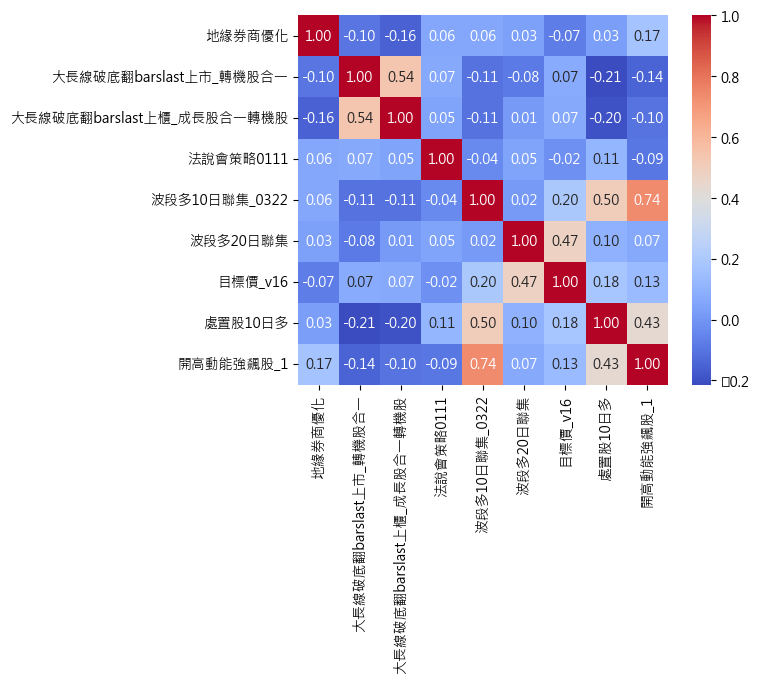

In [25]:
get_portfolio_corr(portfolio_df, portfolio_cols, [col + '_holding_money' for col in portfolio_cols] )

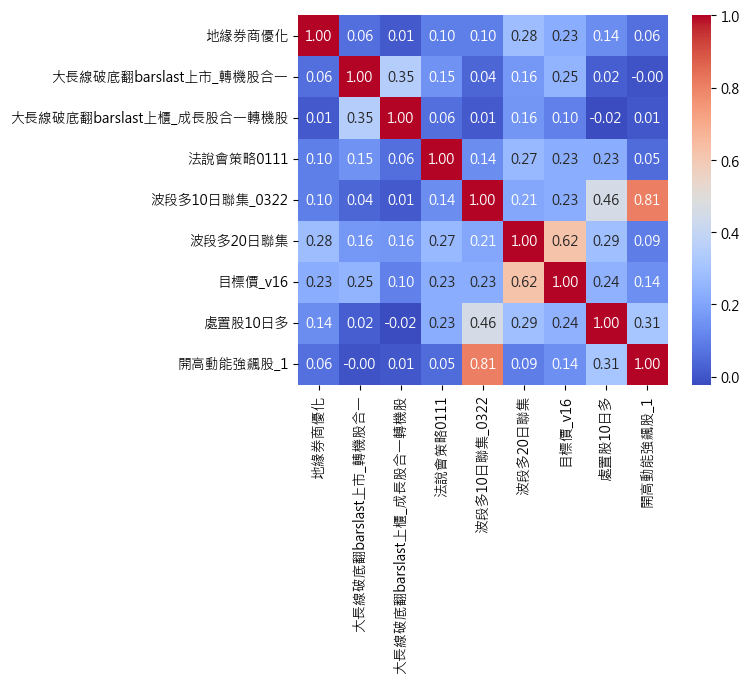

In [26]:
get_portfolio_corr(portfolio_df, portfolio_cols, [col + '_profit' for col in portfolio_cols] )

In [27]:
plot_holding_money_line(portfolio_df_slr, portfolio_cols)

In [28]:
plot_holding_money_bar(portfolio_df_slr, portfolio_cols)

In [29]:
plot_holding_money_box(portfolio_df_slr, portfolio_cols)